# Titanic – Machine Learning from the disaster

First, we import these libraries below to initialize our project.

In [69]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualizzation
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

## Explore the data

Load the data from the CSV file and understand the structure

In [70]:
train = pd.read_csv("data/train.csv")
print(f"Training set: {train.shape}")
train.head()

Training set: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [71]:
test = pd.read_csv("data/test.csv")
print(f"Test set: {test.shape}")
test.head()

Test set: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Data description

- **survival**: 0 = No, 1 = Yes
- **pclass**: Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd
- **sex**: male or female
- **age**: age in years, is fractional if less than 1
- **sibsp**: the number of siblings or spouses onboard
- **parch**: the number of parents or children onboard
- **ticket**: ticket numbers
- **fare**: passenger fare
- **cabin**: cabin number
- **embarked**: port of embarkation, where C = Cherbourg, Q = Queenstown, S = Southampton

### Missing data

Which columns in the dataset have missing data?

<AxesSubplot:>

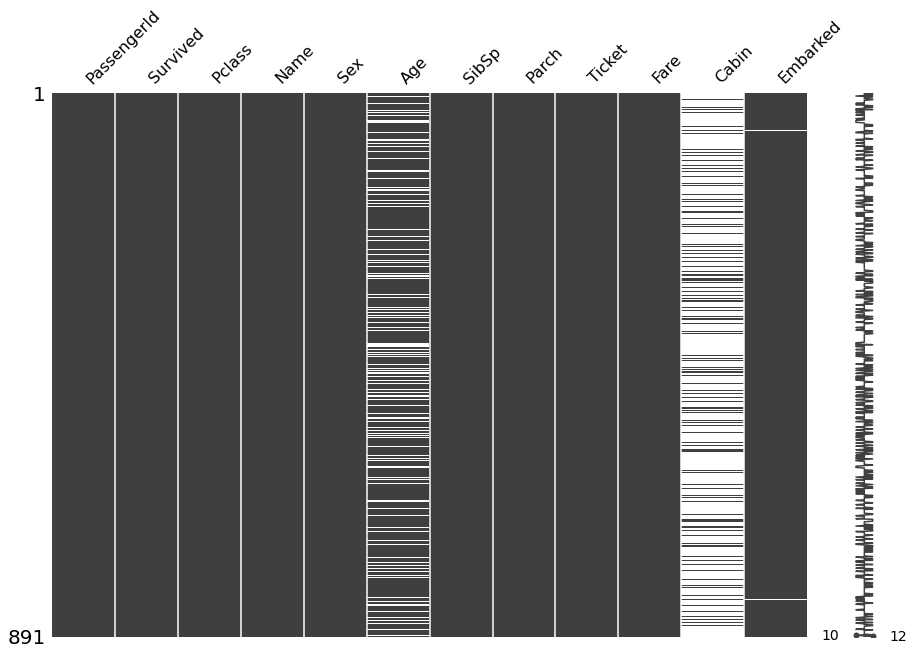

In [72]:
# Columns with missing data in training set
missingno.matrix(train, figsize=(15,10))


<AxesSubplot:>

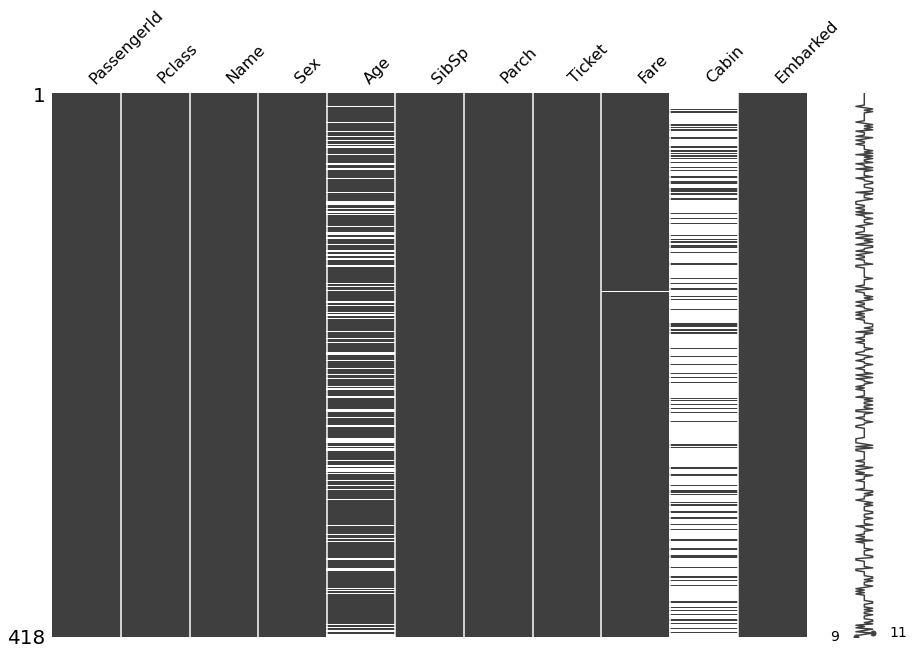

In [73]:
# Columns with missing data in test set
missingno.matrix(test, figsize=(15,10))

## Data analysis

We will epxlore each variable in the data set. This may help us to choose the suitable machine learning models, or whether we need to determine the dataset.

### Categorical variables

- Nominal variables: **Sex**, **Emarked**
- Oridinal variables: **Pclass**

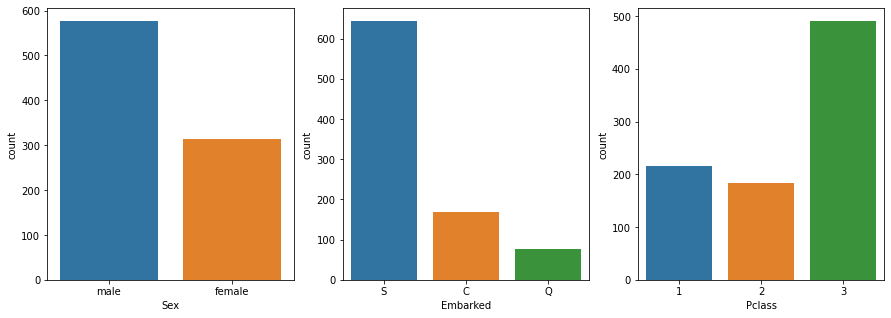

In [74]:
# Get the frequeny of each nominal variables
cat_features = ["Sex", "Embarked", "Pclass"]
f, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(cat_features):
    sns.countplot(x=feature, data=train, ax=axes[i])

#### Insights from counting plots

- There are more male passengers than female passengers
- Most passengers were departed from Southampton
- Most passengers were holding third-class tickets

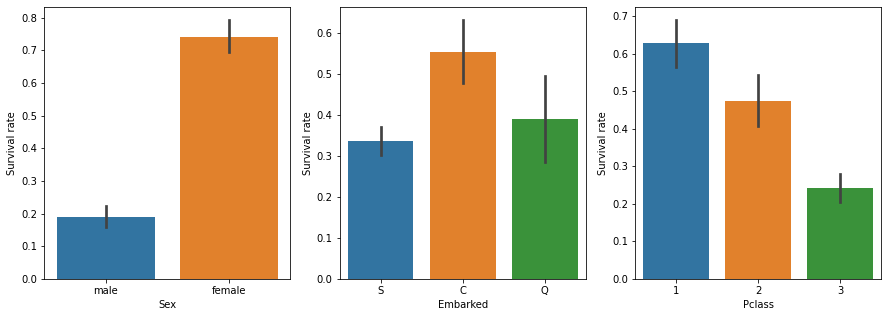

In [75]:
# What is the survival rate based on each categorical variables
f, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(cat_features):
    sns.barplot(x=feature, y="Survived", data=train, ax=axes[i])
    axes[i].set_ylabel("Survival rate")


#### Insights about survival plots

- Female passengers were more likely to survive than male passengers. This may suggests that female passengers were prioritised to evacuate.
- Passengers from Cherbougs were the most likely to survive, while those from Southampton were the least.
- The higher the ticket classes were, the more likely the passengers to survived. This may suggest evacuation priority were based on the ticket class (first-class passengers first, thrid-class passengers last).

### Numerical variables

#### Outliers

Outliers are extreme values which do not conform the majority, and contribute the the skewness of the data set. Having outlier in the dataset may results in learning models with low accuracy. Therefore, we need to filter out these outliers for better models.

For this dataset, the filter is based on interquatile range ($IQR$), which means we will keep the numerical values when they are in range of

$$[Q_1 - 1.5 \cdot (Q_3 - Q_1), Q_3 + 1.5 \cdot (Q_3 - Q_1)]$$

where $Q_1$ is 25th percentile, $Q_3$ is 75th percentile

In [76]:
print(f"Before: {len(train)} rows")

def outliersIndices():
  numerical = train[["SibSp", "Parch", "Age", "Fare"]]
  q1 = numerical.quantile(.25)
  q3 = numerical.quantile(.75)
  iqr = q3 - q1
  low = q1 - 1.5 * iqr
  high = q3 + 1.5 * iqr
  # Only filter out the data if it has more than 2 outlier fields
  outlierCount = (~numerical.isnull() & ((numerical < low) | (numerical > high))).sum(axis=1)
  return outlierCount[outlierCount > 2].index
  
indices = outliersIndices()
print(f"Remove rows: {list(indices)}")

# Filter out
train = train.drop(indices, axis=0).reset_index(drop=True)
print(f"After: {len(train)} rows")


Before: 891 rows
Remove rows: [27, 88, 159, 180, 201, 324, 341, 745, 792, 846, 863]
After: 880 rows


#### Correlation

Some numerical variables may correlate with the survival state

In [77]:
train[["SibSp", "Parch", "Age", "Fare"]].corrwith(train["Survived"])

# Comment: There is some positive correlation between the fare and survival.

SibSp    0.003896
Parch    0.093612
Age     -0.074085
Fare     0.265561
dtype: float64

#### Discrete variables

`SibSp` and `Parch` are discrete variables

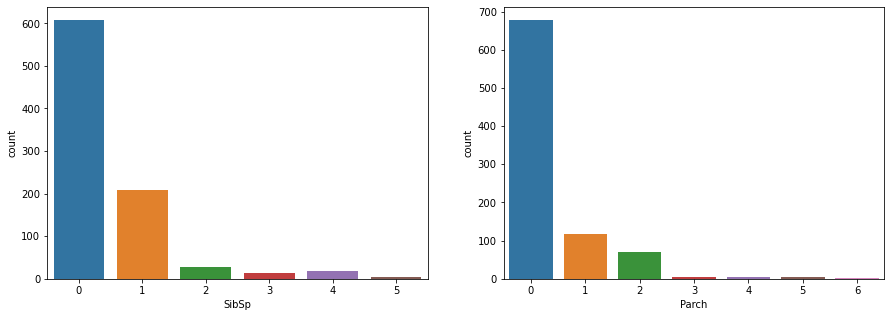

In [78]:
# Counting plots for discrete variables
f, axes = plt.subplots(1, 2, figsize=(15, 5))
discrete = ["SibSp", "Parch"]
for i, feature in enumerate(discrete):
    sns.countplot(x=feature, data=train, ax=axes[i])

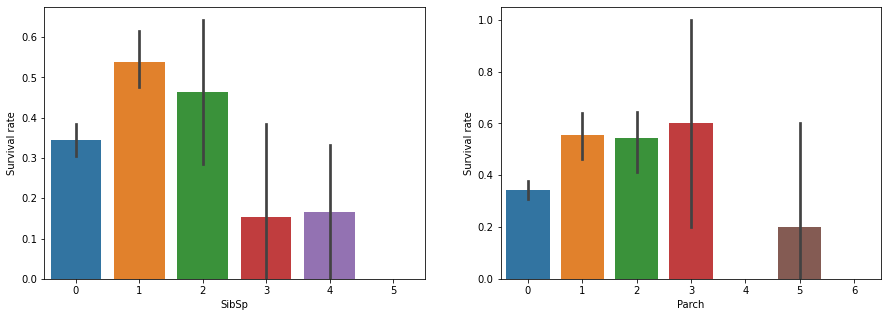

In [79]:
# What are the survival rates for pasenger based on their companions
f, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, feature in enumerate(discrete):
    sns.barplot(x=feature, y="Survived", data=train, ax=axes[i])
    axes[i].set_ylabel("Survival rate")

#### Continuous variables

`Age` and `Fare` are continuous variables in the dataset.

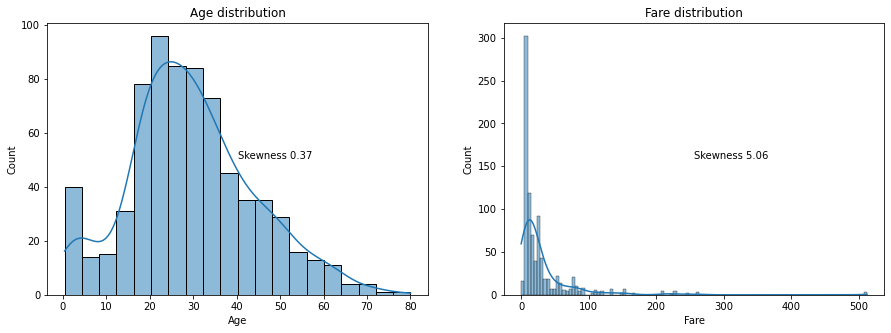

In [80]:
# What is the distribution for the countinuous variables?
f, axes = plt.subplots(1, 2, figsize=(15, 5))
continuous = ["Age", "Fare"]
for i, feature in enumerate(continuous):
    sns.histplot(train[feature], ax=axes[i], kde=True)
    axes[i].annotate("Skewness {:.2f}".format(train[feature].skew()), (0.5,0.5), xycoords="axes fraction")
    axes[i].set_title(f"{feature} distribution")

##### Insights from age and fare distribution

- Age distribution is slightly left-skewed, where younger passengers are conrtbituted significantly to the dataset
- Fare distribution is heavily skewed to the left, which conforms the distribution of ticket classes mentioned in the [catergorical variables analysis](#categorical-variables). Data transformation such as logarithmic transformation is needed in order to reblance the datadistribution

Text(0.5, 1.0, 'Age distribution of non-survivors')

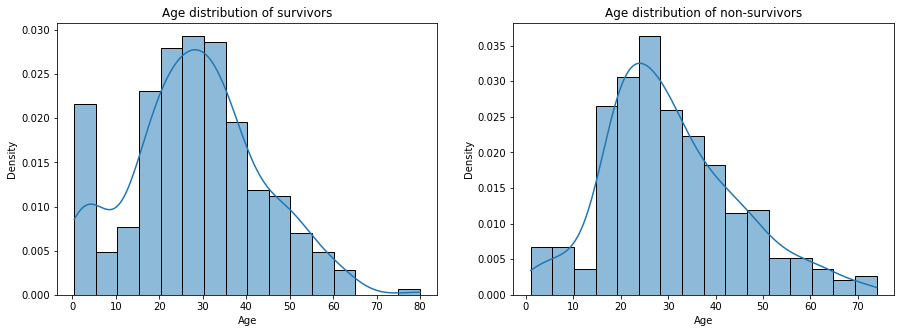

In [81]:
# What are the age and fare distributions of survivors and non-sourvivors?
f, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(train["Age"][train["Survived"] == 1], kde=True, stat="density", ax=axes[0])
axes[0].set_title("Age distribution of survivors")
sns.histplot(train["Age"][train["Survived"] == 0], kde=True, stat="density", ax=axes[1])
axes[1].set_title("Age distribution of non-survivors")

##### Insights from survival age distribution

- Children or passengers of young age are more likely to survive. This may suggest that chidlren were more priorised for evacuation, along with women as mentioned before.

## Data proprocessing

### Feature engineering: `Cabin`, `Ticket`, and `Name`

Since `Cabin`, `Ticket`, and `Name` have too many unqiue values, we have to apply data transformation to extract some useful patterns to cut down the number of categorical values.

#### New feature from `Cabin`: `Deck`

The `Cabin` value is consisted of a letter follow by a number. We'll only extract the letter since it indicates the deck of the Titanic ships, which may have affect on the survival rate of the passengers

Text(0, 0.5, 'Survival rate')

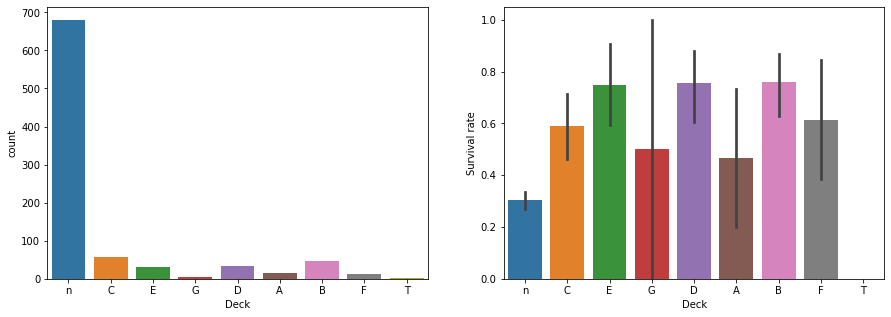

In [82]:
# Extract a letter from the cabin data
# n = null, passenger without a cabin
def extractDeck(data):
  data["Deck"] = data["Cabin"].apply(lambda x: 'n' if pd.isnull(x) else str(x)[0])
  data.drop("Cabin", axis=1, inplace=True)

extractDeck(train)
extractDeck(test)

# Count the frequency
f, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="Deck", data=train, ax=axes[0])

# What is the survival rate based on section?
sns.barplot(x="Deck", y="Survived", data=train, ax=axes[1])
axes[1].set_ylabel("Survival rate")

#### `Ticket`

Since the ticket values generally have letters and numbers. However, since they have many different formats, we cannot find useful pattern in the dataset. Therfore, `Ticket` was dropped from the data set

In [83]:
train.drop("Ticket", axis=1, inplace=True)
test.drop("Ticket", axis=1, inplace=True)

#### New feature from `Name`: `NameTitle`

By exploring the names of the passenger, we found that most of them contains a title (such as Mr. or Mrs.)

In [84]:
# Extract the name title
def extractTitle(data):
  data["NameTitle"] = train["Name"].apply(lambda name: name.split(',')[1].split('.')[0].strip())
  data.drop("Name", axis=1, inplace=True)

extractTitle(test)
extractTitle(train)


# What is the title distribution of name title in training set?
pd.concat([train["NameTitle"], test["NameTitle"]]).value_counts().sort_values(ascending=False)

Mr              743
Miss            276
Mrs             184
Master           61
Dr               10
Rev               9
Don               2
Mme               2
Major             2
Mlle              2
Col               2
Ms                1
Lady              1
Sir               1
the Countess      1
Jonkheer          1
Name: NameTitle, dtype: int64

Text(0, 0.5, 'Survival rate')

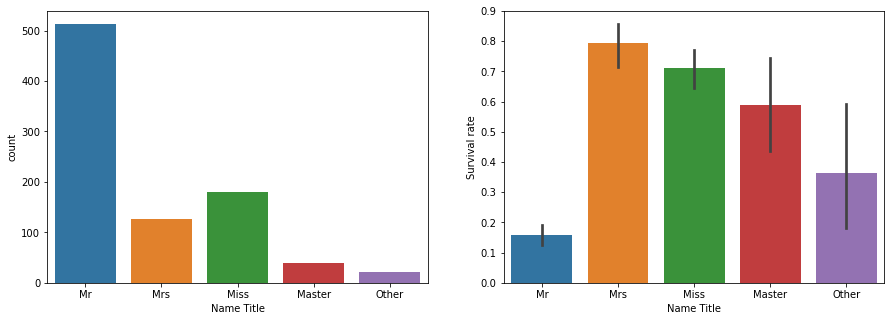

In [85]:
# Clean and group titles together
# Mme -> Mrs
# Ms, Mlle -> Miss
titleMap = {
  "Mme": "Mrs", "Mrs": "Mrs", "Mr": "Mr", "Master": "Master",
  "Miss": "Miss", "Ms": "Miss", "Mlle": "Miss",
}
def cleanTitle(title: str):
  if title in titleMap:
    return titleMap[title]
  return "Other"

# Now, we only have 5 cateogries for name title: Mr, Mrs, Miss, Master, Other
train["NameTitle"] = train["NameTitle"].apply(cleanTitle)
test["NameTitle"] = test["NameTitle"].apply(cleanTitle)

# What is the distrubution and the survival rate?
f, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="NameTitle", data=train, ax=axes[0])
axes[0].set_xlabel("Name Title")

sns.barplot(x="NameTitle", y="Survived", data=train, ax=axes[1])
axes[1].set_xlabel("Name Title")
axes[1].set_ylabel("Survival rate")

### Filling missing data

In [86]:
# Missing data from training set
missing = train.isnull().sum()
missing[missing > 0].sort_values(ascending = False)

Age         170
Embarked      2
dtype: int64

In [87]:
# Missing data from test set
missing = test.isnull().sum()
missing[missing > 0].sort_values(ascending = False)

Age     86
Fare     1
dtype: int64

For the `Embarked` in the training set, the missing data is filled with the most common one

In [88]:
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)

For the `Fare` in the test set, the missing data is filled with the median

In [89]:
test["Fare"].fillna(test["Fare"].dropna().median(), inplace=True)

#### Filling `Age` info

As mentioned before, there are signifincant portion of  passengers without age info.

From the result below, `Pclass`, `Parch`, and `SibSp` are somewhat correlation with `Age`. We can use this information to fill the missing `Age` data

In [90]:
# Binary encoding for sex
train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

# What is the correlation for between categorical and discrete variable and the age?
train[["Sex", "Pclass", "SibSp", "Parch"]].corrwith(train["Age"])

Sex      -0.090351
Pclass   -0.371283
SibSp    -0.310996
Parch    -0.190194
dtype: float64

In [91]:
# How about in the test set?
test[["Sex", "Pclass", "SibSp", "Parch"]].corrwith(test["Age"])

Sex      -0.000013
Pclass   -0.492143
SibSp    -0.091587
Parch    -0.061249
dtype: float64

From both correlation tables above, we found that the `Age` is most correlated to the `Pclass`. We'll that information to fill the missing `Age` data

In [92]:
# Find the rows with with missing Age
def fillAge(data):
  missingAgeRows = data[data["Age"].isnull()].index.tolist()
  meadianAge = data["Age"].dropna().median()

  for i in missingAgeRows:
    # Find the rows with the same Pclass
    predictedAge = data[data["Pclass"] == data.loc[i ,"Pclass"]]["Age"].median()
    if pd.isnull(predictedAge):
      data.loc[i, "Age"] = meadianAge
    else:
      data.loc[i, "Age"] = predictedAge

fillAge(train)
fillAge(test)

### Categorical data encoding

From the current state of the dataset, `Sex` are `Pclass` are previously encoded with numerical values.

Since `NameTitle`, `Deck`, and `Embarked` are nomimal values where each of them has a small number categories, we'll use **Dummy Encoding** scheme for these variables.


In [93]:
# Combine the remaining categorical data
categorical = ["NameTitle", "Deck", "Embarked"]
categoricalWithId = ["PassengerId"] + categorical
combinedCat = pd.concat([train[categoricalWithId], test[categoricalWithId]], ignore_index=True)
combinedCat.head()

,PassengerId,NameTitle,Deck,Embarked
0,1,Mr,n,S
1,2,Mrs,C,C
2,3,Miss,n,S
3,4,Mrs,C,S
4,5,Mr,n,S


In [94]:
# Dummy encoding
dummies = pd.get_dummies(combinedCat[categorical])
dummies = pd.concat([combinedCat["PassengerId"], dummies], axis=1)
train = train.drop(categorical, axis=1).merge(dummies, "left", "PassengerId")
test = test.drop(categorical, axis=1).merge(dummies, "left", "PassengerId")

### Numerical data encoding

In [95]:
# Combine age and fare data from the training and test set
numerical = ["Age", "Fare"]
numericalWithId = ["PassengerId"] + numerical
combinedNum = pd.concat([train[numericalWithId], test[numericalWithId]], ignore_index=True)
combinedNum.head()

,PassengerId,Age,Fare
0,1,22.0,7.2500
1,2,38.0,71.2833
2,3,26.0,7.9250
3,4,35.0,53.1000
4,5,35.0,8.0500


#### `Age` encoding

As mentioned before, the age distribution is quite normal. Thus, we can directly encode it by transform it into ordinal values

In [96]:
combinedNum["AgeClass"] = pd.cut(combinedNum["Age"], 5, labels=range(5))
combinedNum.drop(["Age"], axis=1, inplace=True)

#### `Fare` encoding

As mentioned before, the distribution of `Fare` is heavily skewed to the left. This suggests we should perform data transformation on this data before encoding it. In this case, we choose logarithmic transformation

Skewness: 0.55


<AxesSubplot:xlabel='LogFare', ylabel='Count'>

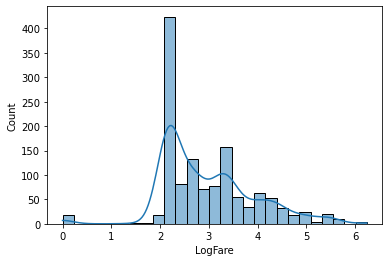

In [97]:
# Logarithmic transformation
combinedNum["LogFare"] = np.log(combinedNum["Fare"] + 1)

# What is the distribution?
print(f"Skewness: {combinedNum['LogFare'].skew():.2f}")
sns.histplot(combinedNum["LogFare"], kde=True)

In [98]:
# Encode to ordinal values
combinedNum["FareClass"] = pd.cut(combinedNum["LogFare"], 6, labels=range(6))

# Drop the temporary columns
combinedNum.drop(["Fare", "LogFare"], axis=1, inplace=True)

# What is the result look like
combinedNum.head()

,PassengerId,AgeClass,FareClass
0,1,1,2
1,2,2,4
2,3,1,2
3,4,2,3
4,5,2,2


In [99]:
# Merge the new encoded data back to the original set
train = train.drop(numerical, axis=1).merge(combinedNum, "left", "PassengerId")
test = test.drop(numerical, axis=1).merge(combinedNum, "left", "PassengerId")

## Final data before modelling

Let's see the structure of two data sets

In [100]:
# What does training set look like?
print(f"Training set: {train.shape}")
train.head()

Training set: (880, 25)


,PassengerId,Survived,Pclass,Sex,SibSp,Parch,NameTitle_Master,NameTitle_Miss,NameTitle_Mr,NameTitle_Mrs,...,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Embarked_C,Embarked_Q,Embarked_S,AgeClass,FareClass
0,1,0,3,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,1,2
1,2,1,1,1,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,2,4
2,3,1,3,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1,2
3,4,1,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,2,3
4,5,0,3,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,2,2


In [101]:
# What does test set look like?
print(f"Test set: {test.shape}")
test.head()

Test set: (418, 24)


,PassengerId,Pclass,Sex,SibSp,Parch,NameTitle_Master,NameTitle_Miss,NameTitle_Mr,NameTitle_Mrs,NameTitle_Other,...,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Embarked_C,Embarked_Q,Embarked_S,AgeClass,FareClass
0,892,3,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,2,2
1,893,3,1,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,2,1
2,894,2,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,3,2
3,895,3,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,1,2
4,896,3,1,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1,2
